In [1]:
# import all required packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc, roc_curve
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.calibration import calibration_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# read the dataset 
df = pd.read_csv("/Users/hkannan/Downloads/AP_ICD_CCI_CC_dataset.csv")

In [4]:
df

,subject_id,hadm_id,charttime,lipase_level,admittime,dischtime,gender,approximate_age_at_admission,race,actual_age,...,amylase_enzyme,alt_enzyme,alp_enzyme,ast_enzyme,creatinine_albumin_ratio,wbc,icd_code,seq_num,icd_version,long_title
0,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,302.0,523.0,252.0,333.0,0.250000,14.1,G40409,1,10,Other generalized epilepsy and epileptic syndr...
1,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,302.0,523.0,252.0,333.0,0.250000,14.1,K8510,2,10,Biliary acute pancreatitis without necrosis or...
2,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,302.0,523.0,252.0,333.0,0.250000,14.1,G9340,3,10,"Encephalopathy, unspecified"
3,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,302.0,523.0,252.0,333.0,0.250000,14.1,K8064,4,10,Calculus of gallbladder and bile duct with chr...
4,10004606,29242151,2159-02-20 18:30:00,1222.0,2159-02-20 13:43:00,2159-03-06 16:51:00,F,64,WHITE,64,...,302.0,523.0,252.0,333.0,0.250000,14.1,E871,5,10,Hypo-osmolality and hyponatremia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34581,19998878,21643535,2132-12-21 15:10:00,570.0,2132-12-20 06:00:00,2132-12-26 13:45:00,M,56,WHITE,56,...,15.0,50.0,430.0,101.0,0.608696,16.5,3572,12,9,Polyneuropathy in diabetes
34582,19998878,21643535,2132-12-21 15:10:00,570.0,2132-12-20 06:00:00,2132-12-26 13:45:00,M,56,WHITE,56,...,15.0,50.0,430.0,101.0,0.608696,16.5,70715,13,9,Ulcer of other part of foot
34583,19998878,21643535,2132-12-21 15:10:00,570.0,2132-12-20 06:00:00,2132-12-26 13:45:00,M,56,WHITE,56,...,15.0,50.0,430.0,101.0,0.608696,16.5,78052,14,9,"Insomnia, unspecified"
34584,19998878,21643535,2132-12-21 15:10:00,570.0,2132-12-20 06:00:00,2132-12-26 13:45:00,M,56,WHITE,56,...,15.0,50.0,430.0,101.0,0.608696,16.5,311,15,9,"Depressive disorder, not elsewhere classified"


In [5]:
missing_counts = df.groupby('subject_id').agg({
    'lipase_level': 'first', 
    'actual_age': 'first',
    'gender': 'first',
    'race': 'first',
    'in_hospital_death': 'max',  # If death recorded in any row, we consider the patient deceased
    'is_confirmed_ap': 'first',
    'charlson_comorbidity_index': 'first', 
    'aniongap_chemistry': 'first',
    'bicarbonate_chemistry': 'first', 
    'bun_chemistry': 'first', 
    'calcium_chemistry': 'first',
    'chloride_chemistry': 'first', 
    'glucose_chemistry': 'first', 
    'sodium_chemistry': 'first',
    'potassium_chemistry': 'first', 
    'bilirubin_total_enzyme': 'first', 
    'amylase_enzyme': 'first',
    'alt_enzyme': 'first', 
    'alp_enzyme': 'first', 
    'ast_enzyme': 'first',
    'wbc': 'first',
    'creatinine_albumin_ratio' : 'first',
    'length_of_stay': 'first'}).isna().sum()

missing_counts/df['subject_id'].nunique()

lipase_level                  0.000000
actual_age                    0.000000
gender                        0.000000
race                          0.000000
in_hospital_death             0.000000
is_confirmed_ap               0.000000
charlson_comorbidity_index    0.000000
aniongap_chemistry            0.007129
bicarbonate_chemistry         0.007129
bun_chemistry                 0.006654
calcium_chemistry             0.026616
chloride_chemistry            0.006654
glucose_chemistry             0.006179
sodium_chemistry              0.006654
potassium_chemistry           0.006654
bilirubin_total_enzyme        0.023764
amylase_enzyme                0.402567
alt_enzyme                    0.019962
alp_enzyme                    0.019962
ast_enzyme                    0.019011
wbc                           0.003802
creatinine_albumin_ratio      0.253327
length_of_stay                0.000000
dtype: float64

In [6]:
missing_cols = list(df.columns[list(df.isna().sum() > 0)])

In [7]:
missing_cols

['aniongap_chemistry',
 'bicarbonate_chemistry',
 'bun_chemistry',
 'calcium_chemistry',
 'chloride_chemistry',
 'glucose_chemistry',
 'sodium_chemistry',
 'potassium_chemistry',
 'bilirubin_total_enzyme',
 'amylase_enzyme',
 'alt_enzyme',
 'alp_enzyme',
 'ast_enzyme',
 'creatinine_albumin_ratio',
 'wbc']

In [8]:
for column in missing_cols:
    median = df[column].median()
    df[column].fillna(value = median, inplace = True)

In [9]:
# concatenate all unique diseases as features
disease_dummies = pd.get_dummies(df['long_title'])
data = pd.concat([df, disease_dummies], axis = 1).drop('long_title', axis = 1)

In [10]:
# aggregate all the rows into unique patients based on subject_id
aggregated_data = data.groupby('subject_id').agg({
    'lipase_level': 'first', 
    'actual_age': 'first',
    'gender': 'first',
    'race': 'first',
    'in_hospital_death': 'max',  # If death recorded in any row, we consider the patient deceased
    'charlson_comorbidity_index': 'first', 
    'aniongap_chemistry': 'first',
    'bicarbonate_chemistry': 'first', 
    'bun_chemistry': 'first', 
    'calcium_chemistry': 'first',
    'chloride_chemistry': 'first', 
    'glucose_chemistry': 'first', 
    'sodium_chemistry': 'first',
    'potassium_chemistry': 'first', 
    'bilirubin_total_enzyme': 'first', 
    'amylase_enzyme': 'first',
    'alt_enzyme': 'first', 
    'alp_enzyme': 'first', 
    'ast_enzyme': 'first', 
    'wbc': 'first',
    'creatinine_albumin_ratio' : 'first',
    'length_of_stay': 'first',
    'is_confirmed_ap': 'first',
    **{col: 'max' for col in disease_dummies.columns}  # max for binary disease presence across multiple rows
}).reset_index()

In [11]:
aggregated_data

,subject_id,lipase_level,actual_age,gender,race,in_hospital_death,charlson_comorbidity_index,aniongap_chemistry,bicarbonate_chemistry,bun_chemistry,...,"Vomiting, unspecified",Von Willebrand's disease,Weakness,"Wedge compression fracture of T7-T8 vertebra, initial encounter for closed fracture","Wedge compression fracture of fourth thoracic vertebra, initial encounter for closed fracture",Wegener's granulomatosis,Wernicke's encephalopathy,Wheelchair dependence,Wheezing,Zoster without complications
0,10004606,1222.0,64,F,WHITE,False,4,20.0,28.0,11.0,...,False,False,False,False,False,False,False,False,False,False
1,10006431,508.0,67,F,WHITE,False,3,17.0,27.0,9.0,...,False,False,False,False,False,False,False,False,False,False
2,10017531,1164.0,64,M,WHITE,False,4,22.0,37.0,51.0,...,False,False,False,False,False,False,False,False,False,False
3,10021357,1249.0,91,F,WHITE,False,4,14.0,29.0,17.0,...,False,False,False,False,False,False,False,False,False,False
4,10036086,677.0,58,M,WHITE,False,2,27.0,29.0,82.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,19970491,487.0,57,M,WHITE,False,2,16.0,32.0,26.0,...,False,False,False,False,False,False,False,False,False,False
2100,19977727,528.0,64,F,WHITE,False,3,12.0,25.0,11.0,...,False,False,False,False,False,False,False,False,False,False
2101,19990545,1886.0,43,F,ASIAN - ASIAN INDIAN,False,1,19.0,26.0,15.0,...,False,False,False,False,False,False,False,False,False,False
2102,19996968,508.0,32,M,BLACK/AFRICAN AMERICAN,False,0,16.0,31.0,6.0,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# grouping all variants of AP into single column
columns_to_drop = [col for col in aggregated_data.columns if 'acute pancreatitis' in col.lower()]
columns_to_drop,len(columns_to_drop)

(['Acute pancreatitis',
  'Acute pancreatitis with infected necrosis, unspecified',
  'Acute pancreatitis with uninfected necrosis, unspecified',
  'Acute pancreatitis without necrosis or infection, unspecified',
  'Acute pancreatitis, unspecified',
  'Alcohol induced acute pancreatitis',
  'Alcohol induced acute pancreatitis with infected necrosis',
  'Alcohol induced acute pancreatitis with uninfected necrosis',
  'Alcohol induced acute pancreatitis without necrosis or infection',
  'Biliary acute pancreatitis',
  'Biliary acute pancreatitis with infected necrosis',
  'Biliary acute pancreatitis with uninfected necrosis',
  'Biliary acute pancreatitis without necrosis or infection',
  'Drug induced acute pancreatitis',
  'Drug induced acute pancreatitis with uninfected necrosis',
  'Drug induced acute pancreatitis without necrosis or infection',
  'Idiopathic acute pancreatitis',
  'Idiopathic acute pancreatitis without necrosis or infection',
  'Other acute pancreatitis',
  'Other a

In [13]:
aggregated_data.drop(columns = columns_to_drop, inplace = True)
aggregated_data['Acute pancreatitis'] = aggregated_data['is_confirmed_ap']
aggregated_data

,subject_id,lipase_level,actual_age,gender,race,in_hospital_death,charlson_comorbidity_index,aniongap_chemistry,bicarbonate_chemistry,bun_chemistry,...,Von Willebrand's disease,Weakness,"Wedge compression fracture of T7-T8 vertebra, initial encounter for closed fracture","Wedge compression fracture of fourth thoracic vertebra, initial encounter for closed fracture",Wegener's granulomatosis,Wernicke's encephalopathy,Wheelchair dependence,Wheezing,Zoster without complications,Acute pancreatitis
0,10004606,1222.0,64,F,WHITE,False,4,20.0,28.0,11.0,...,False,False,False,False,False,False,False,False,False,True
1,10006431,508.0,67,F,WHITE,False,3,17.0,27.0,9.0,...,False,False,False,False,False,False,False,False,False,True
2,10017531,1164.0,64,M,WHITE,False,4,22.0,37.0,51.0,...,False,False,False,False,False,False,False,False,False,True
3,10021357,1249.0,91,F,WHITE,False,4,14.0,29.0,17.0,...,False,False,False,False,False,False,False,False,False,True
4,10036086,677.0,58,M,WHITE,False,2,27.0,29.0,82.0,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,19970491,487.0,57,M,WHITE,False,2,16.0,32.0,26.0,...,False,False,False,False,False,False,False,False,False,True
2100,19977727,528.0,64,F,WHITE,False,3,12.0,25.0,11.0,...,False,False,False,False,False,False,False,False,False,True
2101,19990545,1886.0,43,F,ASIAN - ASIAN INDIAN,False,1,19.0,26.0,15.0,...,False,False,False,False,False,False,False,False,False,True
2102,19996968,508.0,32,M,BLACK/AFRICAN AMERICAN,False,0,16.0,31.0,6.0,...,False,False,False,False,False,False,False,False,False,True


<H1>EDA</H1>

In [14]:
# check if null values are present in the dataset
aggregated_data.isna().sum()

subject_id                      0
lipase_level                    0
actual_age                      0
gender                          0
race                            0
                               ..
Wernicke's encephalopathy       0
Wheelchair dependence           0
Wheezing                        0
Zoster without complications    0
Acute pancreatitis              0
Length: 3879, dtype: int64

### Dataset Overview 

In [73]:
aggregated_data['is_confirmed_ap'].value_counts()

is_confirmed_ap
True     1346
False     758
Name: count, dtype: int64

In [74]:
aggregated_data['in_hospital_death'].value_counts()

in_hospital_death
False    1937
True      167
Name: count, dtype: int64

In [75]:
count_AP_and_death = aggregated_data[(aggregated_data['is_confirmed_ap'] == True) & (aggregated_data['in_hospital_death'] == True)].shape[0]

# Count where 'a' is False and 'b' is True
count_NOT_AP_and_death = aggregated_data[(aggregated_data['is_confirmed_ap'] == False) & (aggregated_data['in_hospital_death'] == True)].shape[0]

print("Count when patient was diagnosed with AP and died:", count_AP_and_death)
print("Count when patient was not diagnosed with AP and died:", count_NOT_AP_and_death)

Count when patient was diagnosed with AP and died: 69
Count when patient was not diagnosed with AP and died: 98


In [76]:
Total_patients = 180677
AP_count = [3849, 1346]
AP_death = [141, 69]

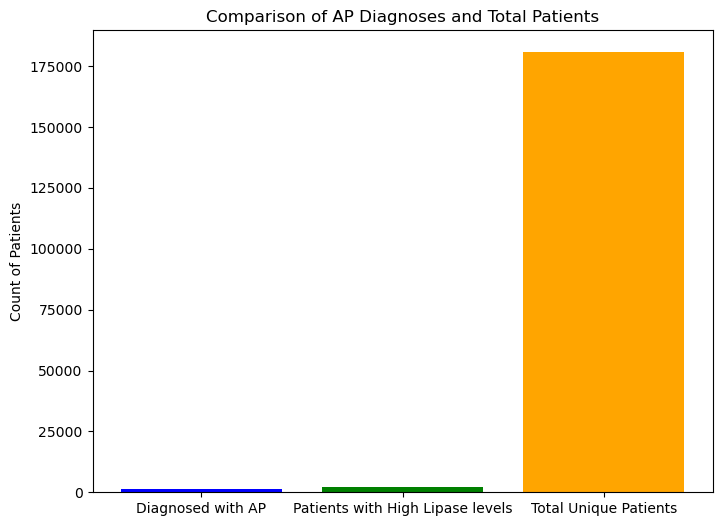

In [82]:
count_diagnosed_with_AP = aggregated_data['is_confirmed_ap'].value_counts()[True]
High_lipase_count = len(aggregated_data)
total_unique_patients = Total_patients

# Labels and counts
labels = ['Diagnosed with AP', 'Patients with High Lipase levels', 'Total Unique Patients']
counts = [count_diagnosed_with_AP, High_lipase_count, total_unique_patients]

# Create bar chart
plt.figure(figsize = (8, 6))  # Set figure size
plt.bar(labels, counts, color = ['blue', 'green', 'orange'])  # Plot bars with different colors

# Adding titles and labels
plt.title('Comparison of AP Diagnoses and Total Patients')
plt.ylabel('Count of Patients')

# Show plot
plt.show()

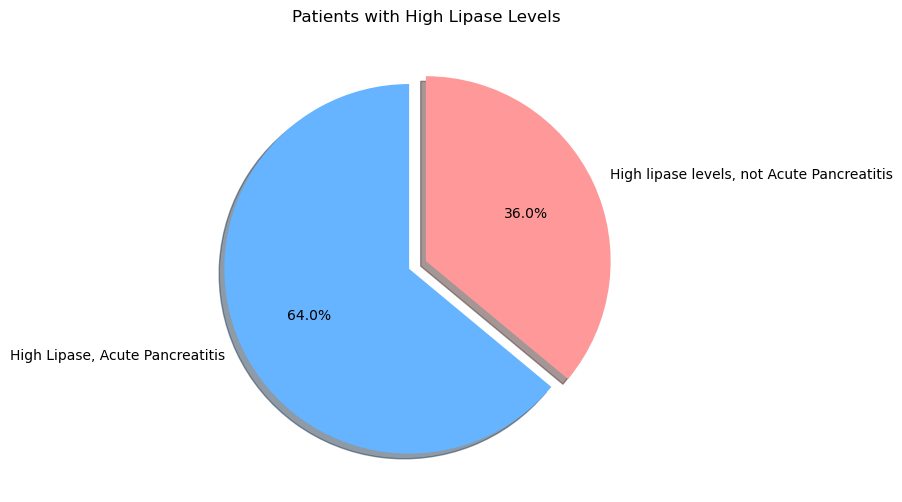

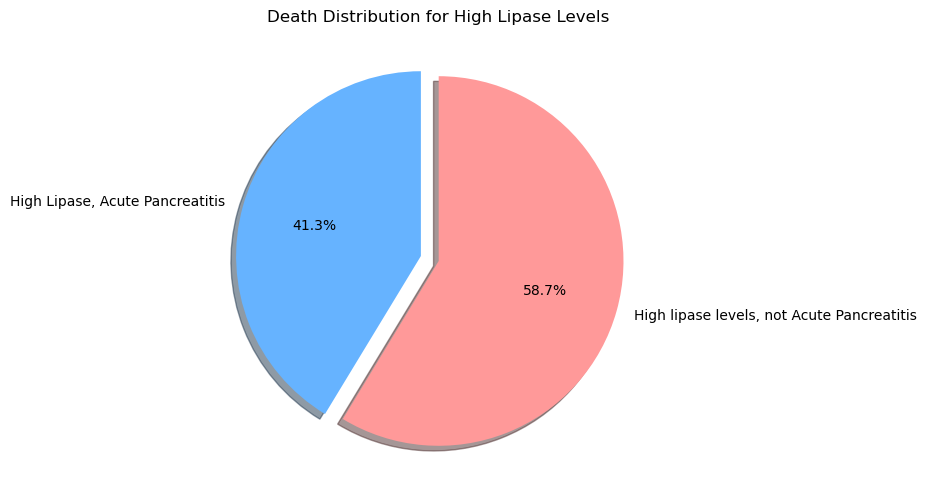

In [77]:
import matplotlib.pyplot as plt

# Labels for the slices
labels_group1 = ['High Lipase, Acute Pancreatitis', 'High lipase levels, not Acute Pancreatitis']

# Colors and explode values for better visual distinction
colors = ['#66b3ff', '#ff9999']  # Light blue for the first category, light red for the second
explode = (0.1, 0)  # Only explode the first slice

counts_group1_exclusive = [aggregated_data['is_confirmed_ap'].value_counts()[True], aggregated_data['is_confirmed_ap'].value_counts()[False]]
deaths_group1_exclusive = [count_AP_and_death, count_NOT_AP_and_death]

# First Pie Chart
plt.figure(figsize = (8, 6))
plt.pie(counts_group1_exclusive, labels=labels_group1, autopct = '%1.1f%%', startangle = 90,
        colors = colors, explode = explode, shadow = True, textprops = {'fontsize': 10})
plt.title('Patients with High Lipase Levels', fontsize = 12)
plt.show()

# Second Pie Chart
plt.figure(figsize = (8, 6))
plt.pie(deaths_group1_exclusive, labels=labels_group1, autopct = '%1.1f%%', startangle = 90,
        colors = colors, explode = explode, shadow = True, textprops = {'fontsize': 10})
plt.title('Death Distribution for High Lipase Levels', fontsize = 12)
plt.show()


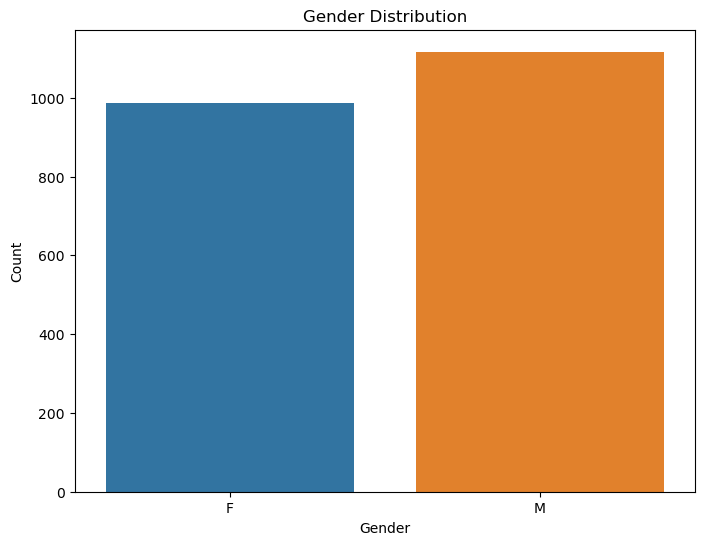

In [57]:
# visualize the distribution of data (features)
# Gender
plt.figure(figsize = (8, 6))
sns.countplot(x = 'gender', data = aggregated_data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

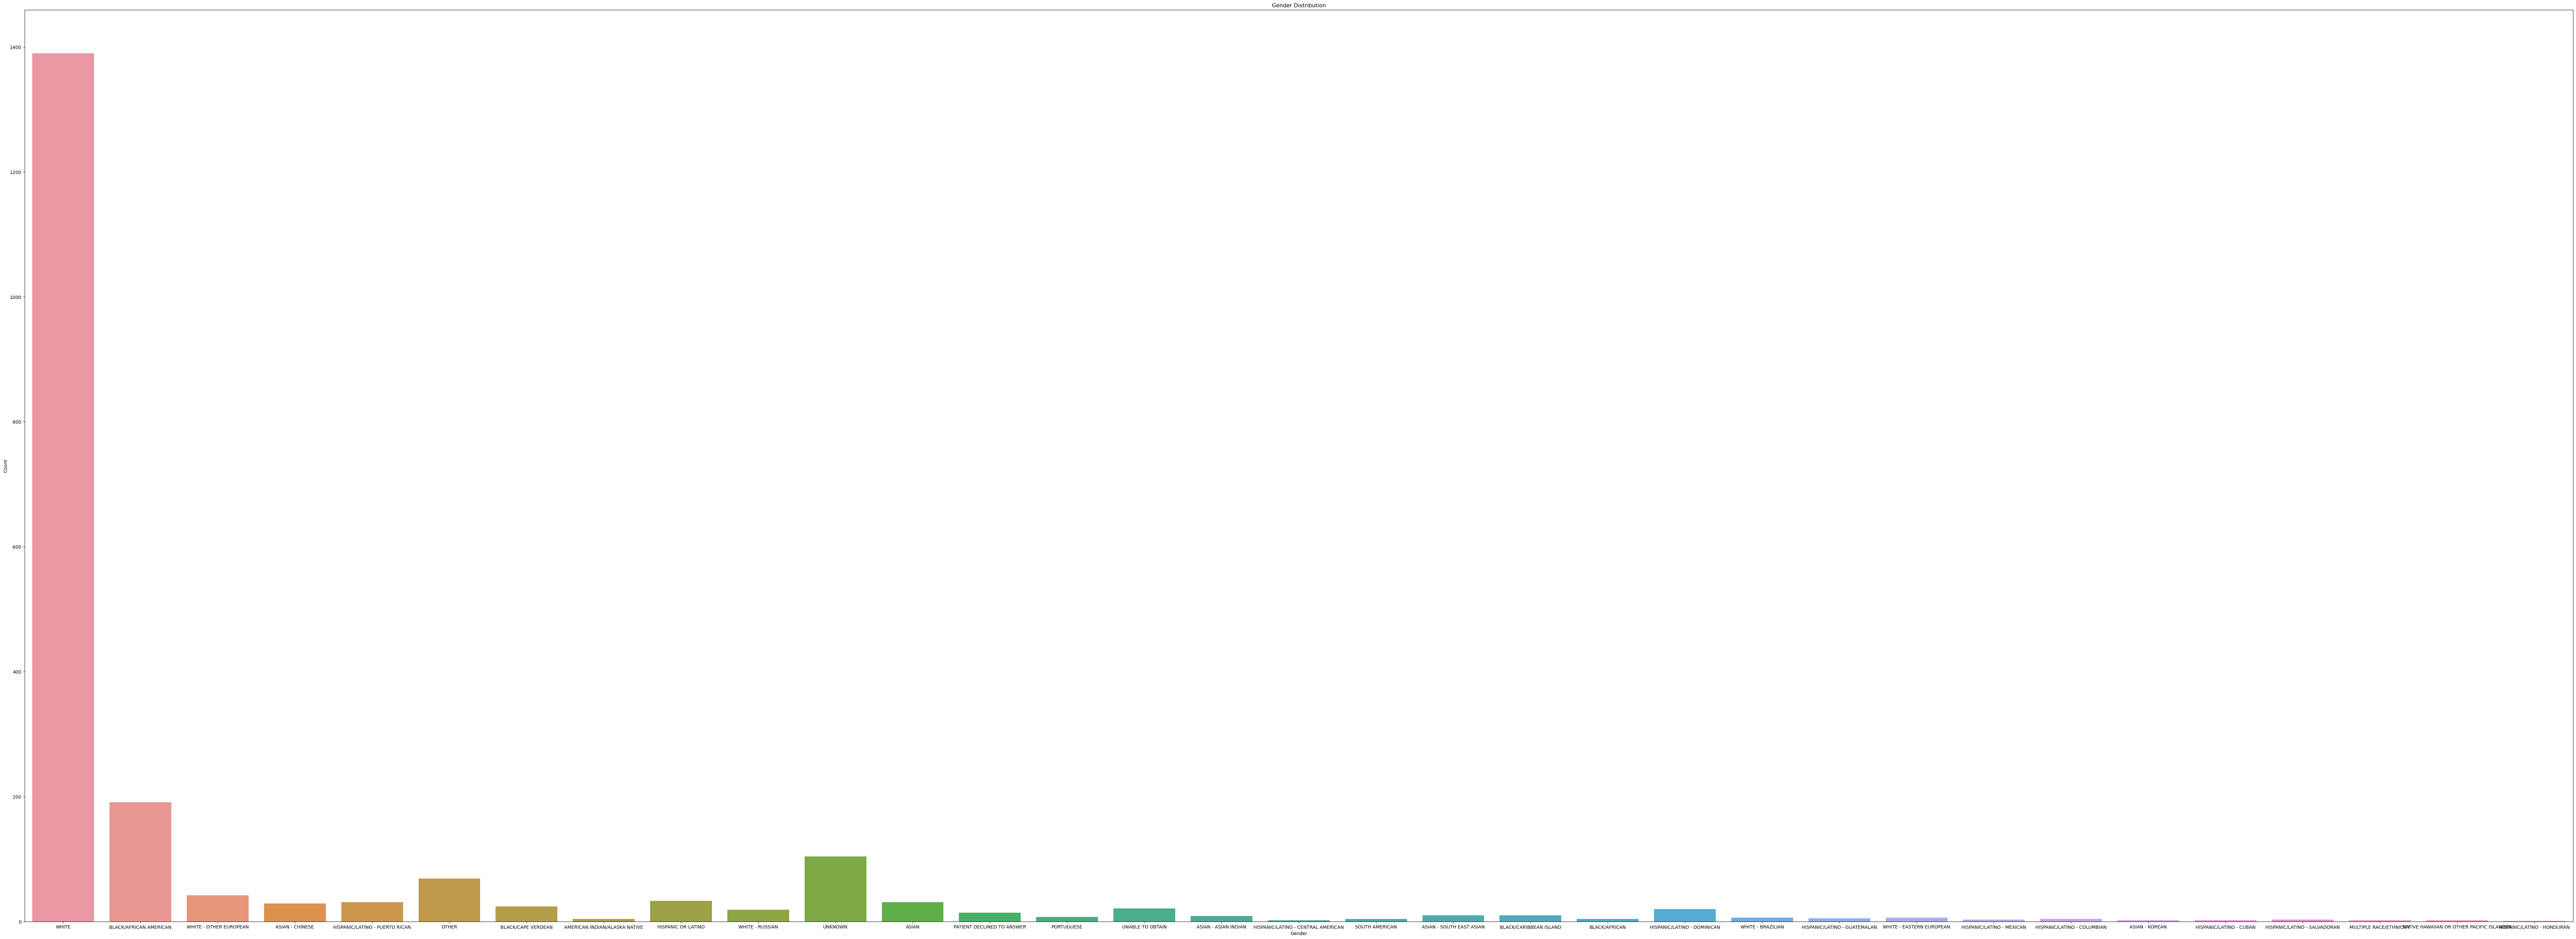

In [58]:
# Race
plt.figure(figsize = (100, 36))
sns.countplot(x = 'race', data = aggregated_data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

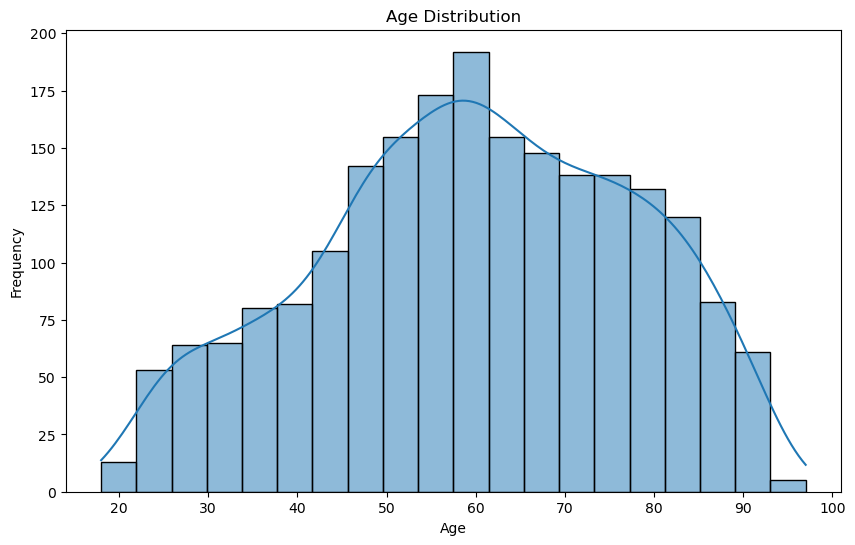

In [60]:
# Age
plt.figure(figsize = (10, 6))
sns.histplot(aggregated_data['actual_age'], bins = 20, kde = True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

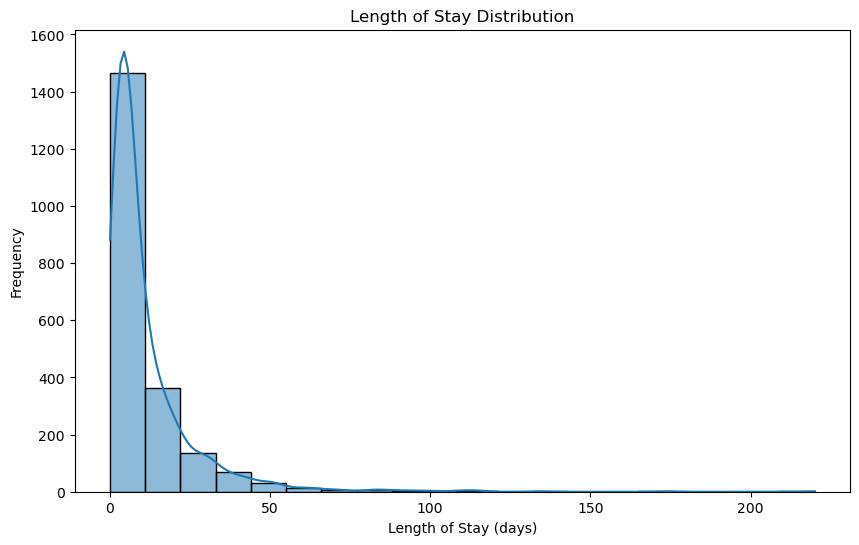

In [61]:
# Length of stay
plt.figure(figsize = (10, 6))
sns.histplot(aggregated_data['length_of_stay'], bins = 20, kde = True)
plt.title('Length of Stay Distribution')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')
plt.show()

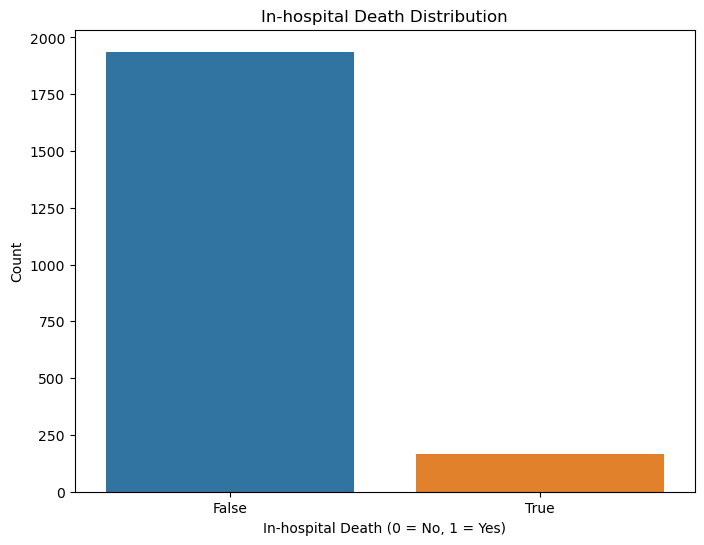

In [62]:
# In-hospital death
plt.figure(figsize = (8, 6))
sns.countplot(x = 'in_hospital_death', data = aggregated_data)
plt.title('In-hospital Death Distribution')
plt.xlabel('In-hospital Death (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

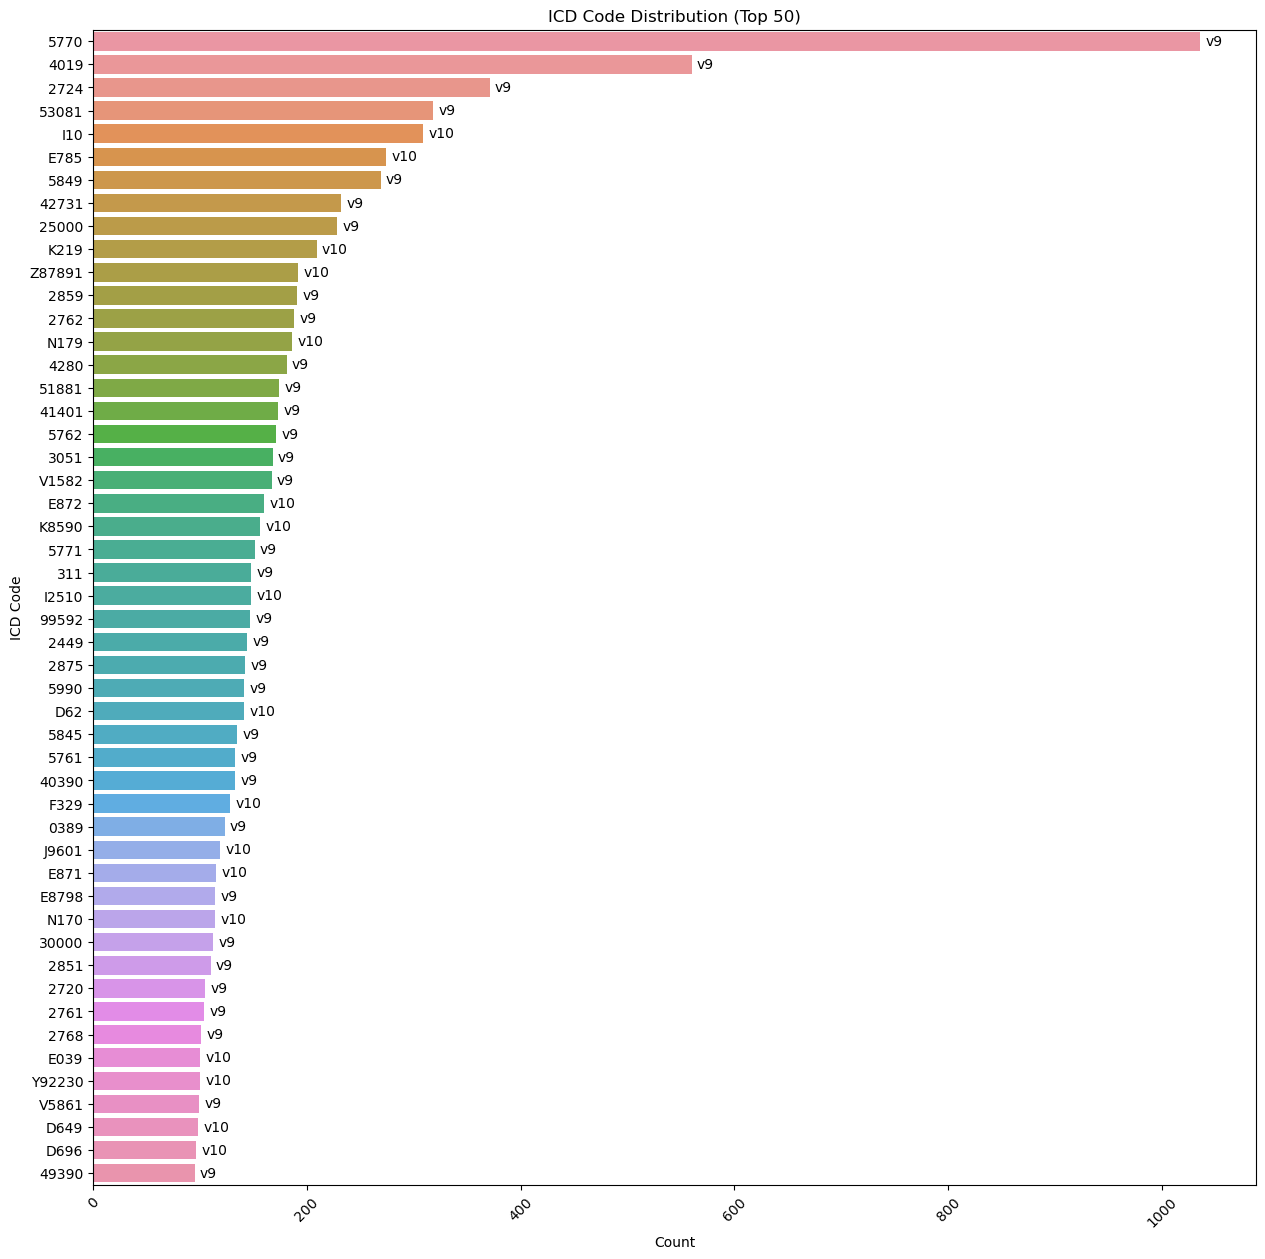

In [63]:
# ICD codes distribution
plt.figure(figsize = (15, 15))
ax = sns.countplot(y = 'icd_code',
                   data = df,
                   order = df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')
for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:50][index]
    icd_version = df.loc[df['icd_code'] == icd_code, 'icd_version'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'v{icd_version}', va='center')
plt.xticks(rotation=45)
plt.show()

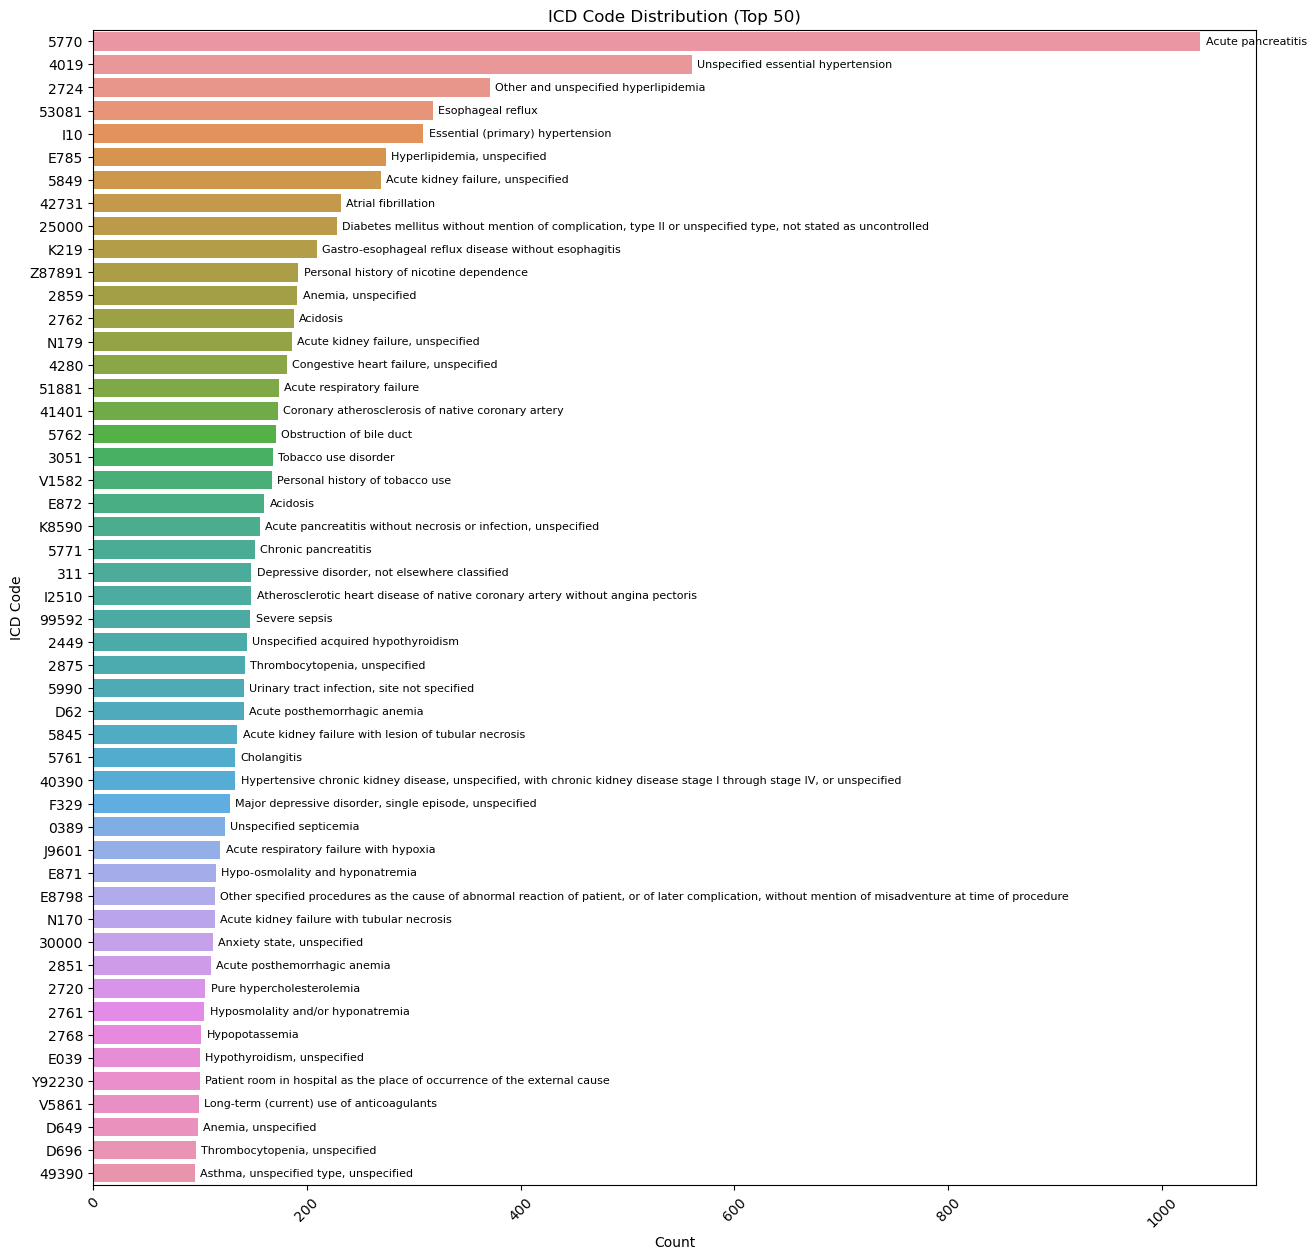

In [117]:
# ICD codes distribution
plt.figure(figsize = (15, 15))
ax = sns.countplot(y = 'icd_code',
                   data = df,
                   order = df['icd_code'].value_counts().index[:50])
plt.title('ICD Code Distribution (Top 50)')
plt.xlabel('Count')
plt.ylabel('ICD Code')

for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:50][index]
    long_title = df.loc[df['icd_code'] == icd_code, 'long_title'].iloc[0]
    x = patch.get_width() + 5
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'{long_title}', va='center', fontsize=8, color='black')

plt.xticks(rotation=45)
plt.show()

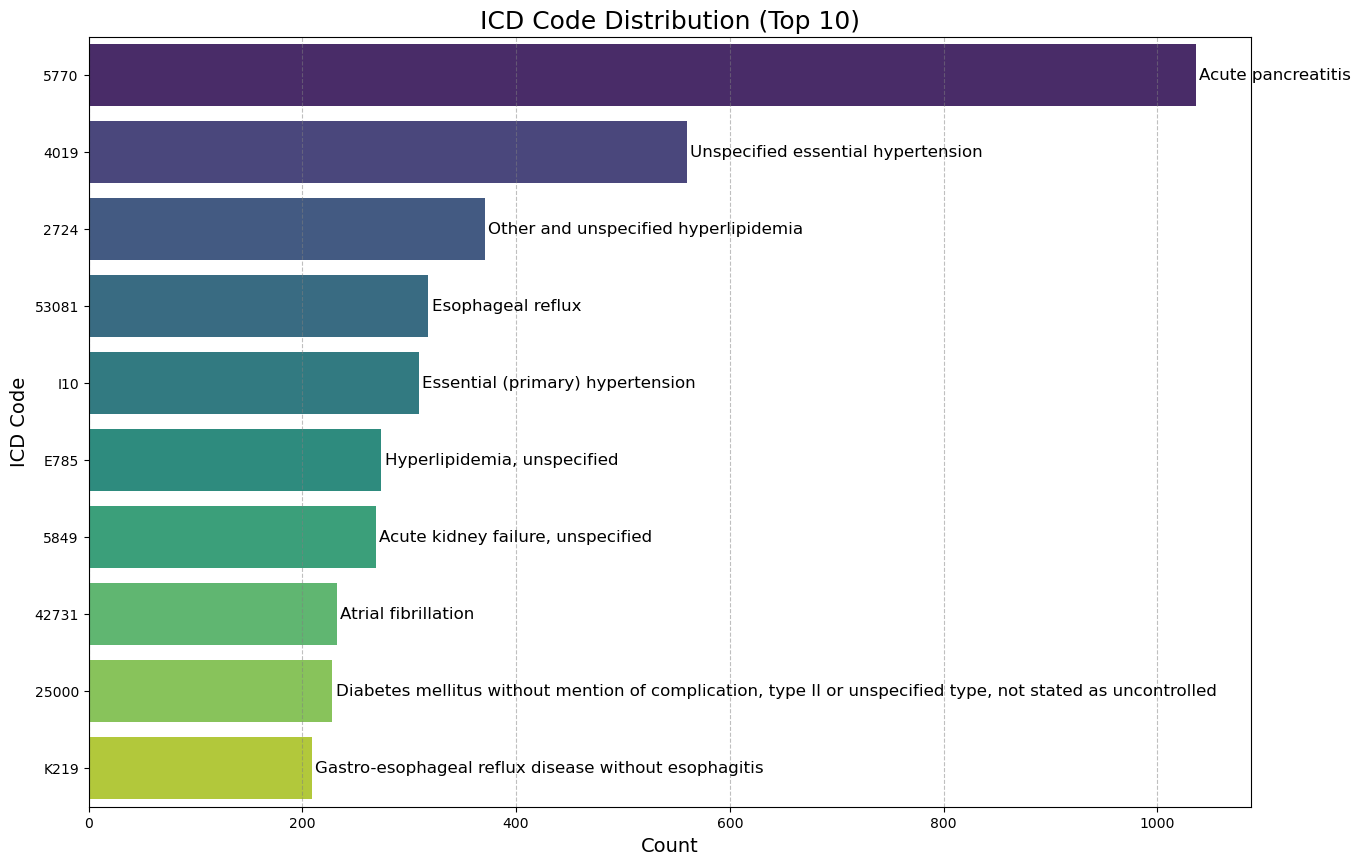

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data setup
# Assuming 'df' is your DataFrame and 'icd_code' and 'long_title' are your columns

# Create a figure and a bar plot
plt.figure(figsize=(15, 10))  # Adjusted for better aspect ratio
ax = sns.countplot(y='icd_code',
                   data=df,
                   order=df['icd_code'].value_counts().index[:10],
                   palette='viridis')  # A more appealing color palette

# Enhance plot titles and labels
plt.title('ICD Code Distribution (Top 10)', fontsize=18)  # Corrected from Top 50 to Top 10 as shown in the order
plt.xlabel('Count', fontsize=14)
plt.ylabel('ICD Code', fontsize=14)

# Improve annotations
for index, patch in enumerate(ax.patches):
    icd_code = df['icd_code'].value_counts().index[:10][index]
    long_title = df.loc[df['icd_code'] == icd_code, 'long_title'].iloc[0]
    x = patch.get_width() + 3  # Adjusted for better space management
    y = patch.get_y() + patch.get_height() / 2
    ax.text(x, y, f'{long_title}', va='center', ha='left', fontsize=12, color='black')  # Adjusted text alignment and size

# Add grid lines for better readability
plt.grid(True, linestyle='--', which='major', color='grey', alpha=0.5, axis='x')

# Show the plot with improved aesthetics
plt.show()


<H1>Feature Selection</H1>

In [15]:
X = aggregated_data.drop(['subject_id', 'in_hospital_death', 'is_confirmed_ap'], axis = 1)
y = aggregated_data['in_hospital_death'].astype(int)  # Converting boolean to int

X_encoded = X.apply(LabelEncoder().fit_transform)

# Apply Chi-squared test
chi2_features = SelectKBest(score_func = chi2, k = 'all')  # 'all' to test each feature
chi2_features.fit(X_encoded, y)
chi2_scores = pd.DataFrame(chi2_features.scores_, columns = ['score'], index = X.columns)
chi2_p_values = pd.DataFrame(chi2_features.pvalues_, columns = ['p-value'], index = X.columns)
chi2_results = pd.concat([chi2_scores, chi2_p_values], axis=1)

print(chi2_results.sort_values(by = 'score', ascending = False))  

                                                           score   p-value
ast_enzyme                                          39580.124156  0.000000
creatinine_albumin_ratio                            23734.764469  0.000000
alt_enzyme                                          13767.373023  0.000000
bilirubin_total_enzyme                              11449.478608  0.000000
wbc                                                 11207.159812  0.000000
...                                                          ...       ...
Hyperlipidemia, unspecified                             0.000813  0.977252
Osteoporosis, unspecified                               0.000269  0.986906
Long-term (current) use of aspirin                      0.000269  0.986906
Acute respiratory failure following trauma and ...      0.000135  0.990741
Benign prostatic hyperplasia without lower urin...      0.000094  0.992263

[3876 rows x 2 columns]


In [16]:
significant_features = chi2_results[chi2_results['p-value'] < 0.05]
significant_features.index, len(significant_features)

(Index(['lipase_level', 'actual_age', 'charlson_comorbidity_index',
        'aniongap_chemistry', 'bicarbonate_chemistry', 'bun_chemistry',
        'calcium_chemistry', 'chloride_chemistry', 'glucose_chemistry',
        'sodium_chemistry',
        ...
        'Vascular disorder of intestine, unspecified',
        'Vascular disorders of kidney', 'Ventilator associated pneumonia',
        'Ventricular fibrillation',
        'Ventricular septal defect as current complication following acute myocardial infarction',
        'Ventricular tachycardia',
        'Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta',
        'Vitamin B12 deficiency anemia due to intrinsic factor deficiency',
        'Volvulus', 'Acute pancreatitis'],
       dtype='object', length=600),
 600)

<H1>Modelling</H1>

In [17]:
# defining features and labels to fit the models
X = aggregated_data.drop(['subject_id', 'in_hospital_death'], axis = 1)
y = aggregated_data['in_hospital_death'].astype(int)  # Converting boolean to int

# Encoding categorical variables and scaling numerical features
categorical_features = ['gender', 'race', 'charlson_comorbidity_index']

X = X[categorical_features[:2] + list(significant_features.index)] 

X = X.drop(['amylase_enzyme', 'creatinine_albumin_ratio'], axis = 1) # many missing values

last_initial_numeric_index = X.columns.tolist().index('length_of_stay')

disease_features = X.columns[last_initial_numeric_index + 1:].tolist()

# Complete list of numeric features now includes the disease vector columns
numeric_features = ['lipase_level', 
 'actual_age',  
 'aniongap_chemistry',
 'bicarbonate_chemistry',
 'bun_chemistry',
 'calcium_chemistry',
 'chloride_chemistry',
 'glucose_chemistry',
 'sodium_chemistry',
 'potassium_chemistry',
 'bilirubin_total_enzyme',
 'alt_enzyme',
 'alp_enzyme',
 'ast_enzyme',
 'wbc',
 'length_of_stay']

binary_features = disease_features  # Assuming these are correctly identified in your code

#svd_transformer = Pipeline(steps=[
#    ('svd', TruncatedSVD(n_components = 100, random_state = 42)) # select only top 100 components for the binary features (diseases)
#])

preprocessor = ColumnTransformer(
    transformers = [ 
        ('num', StandardScaler(), numeric_features),
        #('binary', svd_transformer, binary_features),  # No need to scale binary features
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [18]:
X

,gender,race,lipase_level,actual_age,charlson_comorbidity_index,aniongap_chemistry,bicarbonate_chemistry,bun_chemistry,calcium_chemistry,chloride_chemistry,...,"Vascular disorder of intestine, unspecified",Vascular disorders of kidney,Ventilator associated pneumonia,Ventricular fibrillation,Ventricular septal defect as current complication following acute myocardial infarction,Ventricular tachycardia,"Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta",Vitamin B12 deficiency anemia due to intrinsic factor deficiency,Volvulus,Acute pancreatitis
0,F,WHITE,1222.0,64,4,20.0,28.0,11.0,9.6,110.0,...,False,False,False,False,False,False,False,False,False,True
1,F,WHITE,508.0,67,3,17.0,27.0,9.0,9.6,98.0,...,False,False,False,False,False,False,False,False,False,True
2,M,WHITE,1164.0,64,4,22.0,37.0,51.0,8.4,115.0,...,False,False,False,False,False,False,False,False,False,True
3,F,WHITE,1249.0,91,4,14.0,29.0,17.0,8.8,111.0,...,False,False,False,False,False,False,False,False,False,True
4,M,WHITE,677.0,58,2,27.0,29.0,82.0,9.6,112.0,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,M,WHITE,487.0,57,2,16.0,32.0,26.0,9.7,106.0,...,False,False,False,False,False,False,False,False,False,True
2100,F,WHITE,528.0,64,3,12.0,25.0,11.0,8.7,111.0,...,False,False,False,False,False,False,False,False,False,True
2101,F,ASIAN - ASIAN INDIAN,1886.0,43,1,19.0,26.0,15.0,8.4,102.0,...,False,False,False,False,False,False,False,False,False,True
2102,M,BLACK/AFRICAN AMERICAN,508.0,32,0,16.0,31.0,6.0,9.5,101.0,...,False,False,False,False,False,False,False,False,False,True


In [19]:
# Using Grid Search to perform hyperparameter tuning by 10-fold cross-validation and optimizing for the 'average_precision' scoring metric
models = {
    'Logistic Regression': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', LogisticRegression())]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear']
        }
    },
    
    'Random Forest': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', RandomForestClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    
    'Gradient Boosting': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', GradientBoostingClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    
    'SVM': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    
    'Decision Tree': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', DecisionTreeClassifier())]),
        'params': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    
    'K-Nearest Neighbors': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    
    'AdaBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', AdaBoostClassifier())]),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.5]
        }
    },
    
    'XGBoost': {
        'pipeline': Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 0.9, 1]
        }
}

}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Loop through each model and perform grid search
for name, model in models.items():
    grid_search = GridSearchCV(estimator = model['pipeline'], param_grid = model['params'], cv = 10, scoring = 'average_precision')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Logistic Regression: {'classifier__C': 1.0, 'classifier__solver': 'liblinear'}
Best parameters for Random Forest: {'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best parameters for SVM: {'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Best parameters for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 10}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best parameters for AdaBoost: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best parameters for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 0.7}


In [21]:
# fit all the models with the best parameters and evaluate each of their performance
models = {
    'Logistic Regression': LogisticRegression(C = 1, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 7, n_estimators = 300),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 300),
    'SVM': SVC(C = 0.1, kernel = 'linear',  probability = True),
    'KNN': KNeighborsClassifier(n_neighbors = 7, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 3, min_samples_split = 10, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.1, n_estimators = 200),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', learning_rate = 0.2, max_depth = 7, n_estimators = 100, subsample = 0.7)
}

# Dictionary to store performance
performance = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Evaluate each model
for name, model in models.items():
    # Create and fit the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    # Store performance
    performance[name] = {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1 Score': f1, 
        'ROC AUC': roc_auc
    }
    
    # Print model performance
    print(f"{name} performance: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")

Logistic Regression performance: Accuracy = 0.9549, Precision = 0.8095, Recall = 0.5312, F1 Score = 0.6415, ROC AUC = 0.9525
Random Forest performance: Accuracy = 0.9240, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.9512
Gradient Boosting performance: Accuracy = 0.9454, Precision = 0.7143, Recall = 0.4688, F1 Score = 0.5660, ROC AUC = 0.9320
SVM performance: Accuracy = 0.9430, Precision = 0.7222, Recall = 0.4062, F1 Score = 0.5200, ROC AUC = 0.9357
KNN performance: Accuracy = 0.9216, Precision = 0.0000, Recall = 0.0000, F1 Score = 0.0000, ROC AUC = 0.6509
Decision Tree performance: Accuracy = 0.8219, Precision = 0.2737, Recall = 0.8125, F1 Score = 0.4094, ROC AUC = 0.8675
AdaBoost performance: Accuracy = 0.9430, Precision = 0.7857, Recall = 0.3438, F1 Score = 0.4783, ROC AUC = 0.9285
XGBoost performance: Accuracy = 0.9501, Precision = 0.7391, Recall = 0.5312, F1 Score = 0.6182, ROC AUC = 0.9487


In [49]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor)
])

In [50]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lipase_level', 'actual_age',
                                                   'aniongap_chemistry',
                                                   'bicarbonate_chemistry',
                                                   'bun_chemistry',
                                                   'calcium_chemistry',
                                                   'chloride_chemistry',
                                                   'glucose_chemistry',
                                                   'sodium_chemistry',
                                                   'potassium_chemistry',
                                                   'bilirubin_total_enzyme',
                                                   'alt_enzyme', 'alp_enzyme',
                                                   'ast_enzyme', 'wbc',...
                                                   'failure without coma',
                                                   'Acute and subacute '
                                                   'necrosis of liver',
                                                   'Acute combined systolic '
                                                   '(congestive) and diastolic '
                                                   '(congestive) heart failure',
                                                   'Acute cor pulmonale',
                                                   'Acute embolism and '
                                                   'thrombosis of left '
                                                   'axillary vein',
                                                   'Acute embolism and '
                                                   'thrombosis of left '
                                                   'subclavian vein', ...]),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race',
                                                   'charlson_comorbidity_index'])]))])

In [13]:
#SMOTE

In [20]:
# add SMOTE to the pipeline to deal with class imbalance
smote = SMOTE(random_state = 42)

# Using Grid Search to perform hyperparameter tuning by 10-fold cross-validation and optimizing for the 'average_precision' scoring metric
models = {
    'Logistic Regression': {
        'pipeline': ImbPipeline(steps = [('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', LogisticRegression())]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__solver': ['liblinear']
        }
    },
    'Random Forest': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', RandomForestClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'Gradient Boosting': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', GradientBoostingClassifier())]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7]
        }
    },
    'SVM': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', SVC(probability=True))]),
        'params': {
            'classifier__C': [0.1, 1.0, 10],
            'classifier__kernel': ['linear', 'rbf']
        }
    },
    'Decision Tree': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                        ('pca', PCA(n_components=0.95)),
                                       ('classifier', DecisionTreeClassifier())]),
        'params': {
            'classifier__max_depth': [3, 5, 7, 10],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'K-Nearest Neighbors': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', KNeighborsClassifier())]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'AdaBoost': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                       ('smote', smote),
                                       ('classifier', AdaBoostClassifier())]),
        'params': {
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.5]
        }
    },
    
    'XGBoost': {
        'pipeline': ImbPipeline(steps=[('preprocessor', preprocessor),
                                    ('smote', smote),
                                    ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss'))]),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.7, 0.9, 1]
        }
    }
}

# Loop through each model and perform grid search
for name, model in models.items():
    grid_search = GridSearchCV(estimator = model['pipeline'], param_grid = model['params'], cv = 10, scoring = 'average_precision')
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}
Best parameters for Random Forest: {'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best parameters for Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best parameters for SVM: {'classifier__C': 1.0, 'classifier__kernel': 'rbf'}
Best parameters for Decision Tree: {'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
Best parameters for K-Nearest Neighbors: {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}
Best parameters for AdaBoost: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 100}
Best parameters for XGBoost: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__subsample': 1}


In [49]:
models = {
    'Logistic Regression': LogisticRegression(C = 0.1, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 7,n_estimators = 300),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 300),
    'SVM': SVC(C = 1, kernel = 'rbf', probability = True),
    'KNN': KNeighborsClassifier(n_neighbors =  7, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 3, min_samples_split = 2, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',learning_rate = 0.2, max_depth = 7, n_estimators = 200, subsample = 1)
}
performance = {}

for name, model in models.items():
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    performance[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    print(f"{name} performance: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}, ROC AUC = {roc_auc:.4f}")


Logistic Regression performance: Accuracy = 0.9240, Precision = 0.5000, Recall = 0.7500, F1 Score = 0.6000, ROC AUC = 0.9536
Random Forest performance: Accuracy = 0.9501, Precision = 0.6897, Recall = 0.6250, F1 Score = 0.6557, ROC AUC = 0.9423
Gradient Boosting performance: Accuracy = 0.9430, Precision = 0.6667, Recall = 0.5000, F1 Score = 0.5714, ROC AUC = 0.9402
SVM performance: Accuracy = 0.9454, Precision = 0.6800, Recall = 0.5312, F1 Score = 0.5965, ROC AUC = 0.9458
KNN performance: Accuracy = 0.9097, Precision = 0.4400, Recall = 0.6875, F1 Score = 0.5366, ROC AUC = 0.8159
Decision Tree performance: Accuracy = 0.9145, Precision = 0.4524, Recall = 0.5938, F1 Score = 0.5135, ROC AUC = 0.8756
AdaBoost performance: Accuracy = 0.9335, Precision = 0.5526, Recall = 0.6562, F1 Score = 0.6000, ROC AUC = 0.9283
XGBoost performance: Accuracy = 0.9501, Precision = 0.7037, Recall = 0.5938, F1 Score = 0.6441, ROC AUC = 0.9538


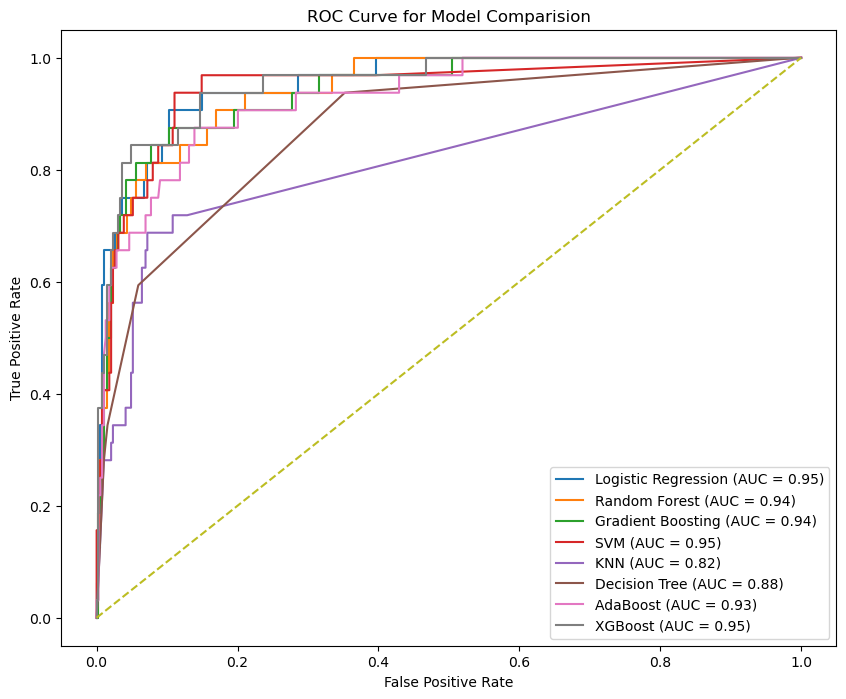

In [71]:
models = {
    'Logistic Regression': LogisticRegression(C = 0.1, solver = 'liblinear'),
    'Random Forest': RandomForestClassifier(max_depth = 7,n_estimators = 300),
    'Gradient Boosting': GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 300),
    'SVM': SVC(C = 1, kernel = 'rbf', probability = True),
    'KNN': KNeighborsClassifier(n_neighbors =  7, weights = 'distance'),
    'Decision Tree': DecisionTreeClassifier(max_depth = 3, min_samples_split = 2, class_weight = 'balanced'),
    'AdaBoost': AdaBoostClassifier(learning_rate = 0.1, n_estimators = 100),
    'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',learning_rate = 0.2, max_depth = 7, n_estimators = 200, subsample = 1)
}

plt.figure(figsize = (10, 8))

# Evaluate each model
for (name, model) in models.items():
    # Train the model
    pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                                  ('smote', smote),
                                  ('classifier', model)])
    pipeline.fit(X_train, y_train)
    
    # Predict probabilities for the positive class
    if hasattr(pipeline, "predict_proba"):
        y_scores = pipeline.predict_proba(X_test)[:, 1]
    else:  # Use decision function for SVM
        y_scores = pipeline.decision_function(X_test)
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, linestyle='-', label=f'{name} (AUC = {roc_auc:.2f})')

# Plot ROC for a random model (no skill)
plt.plot([0, 1], [0, 1], linestyle = '--')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Model Comparision')
plt.legend(loc = "lower right")

# Show the plot
plt.show()

#### XGBOOST

In [25]:
# Creating a pipeline that includes preprocessing and the classifier
XGBC = ImbPipeline(steps=[('preprocessor', preprocessor),
                        ('smote', smote),
                         ('classifier', XGBClassifier(use_label_encoder = False, eval_metric = 'logloss',learning_rate = 0.2, max_depth = 7, n_estimators = 200, subsample = 1))])

# Fitting the model
XGBC.fit(X_train, y_train)

# Model evaluation
train_score = XGBC.score(X_train, y_train)
test_score = XGBC.score(X_test, y_test)

print(train_score, test_score)

y_pred = XGBC.predict(X_test)
y_proba = XGBC.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

probabilities = XGBC.predict_proba(X_test)

# Extracting the probability of death, which is the second column of probabilities
death_probabilities = probabilities[:, 1]

# Showing the first few predictions for interpretation
death_probabilities[:10]

1.0 0.9501187648456056


array([5.4487646e-06, 1.7932587e-05, 9.7138283e-05, 9.3894804e-01,
       4.3148996e-04, 3.7324923e-04, 7.7662432e-01, 1.7395391e-03,
       1.0441805e-05, 2.8407630e-05], dtype=float32)

In [26]:
accuracy, precision, recall, f1, roc_auc

(0.9501187648456056,
 0.7037037037037037,
 0.59375,
 0.6440677966101694,
 0.9538078406169666)

In [27]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       389
           1       0.70      0.59      0.64        32

    accuracy                           0.95       421
   macro avg       0.84      0.79      0.81       421
weighted avg       0.95      0.95      0.95       421



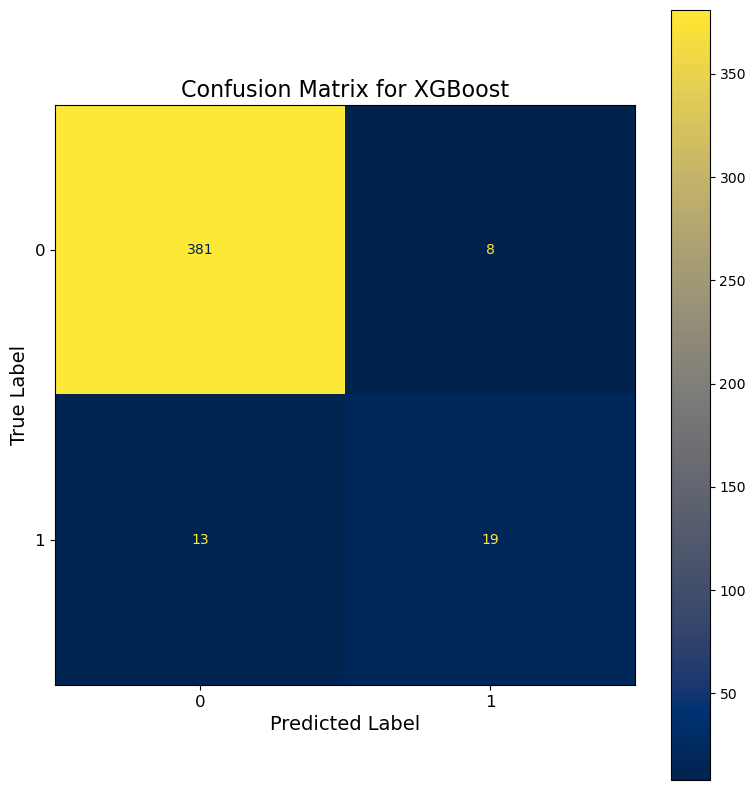

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Create the Confusion Matrix object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_test))

# Plot with enhanced color scheme
fig, ax = plt.subplots(figsize = (8, 8))
cmap = plt.cm.cividis  

disp.plot(cmap = cmap, ax = ax, colorbar = True)
ax.set_title('Confusion Matrix for XGBoost', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12) 

ax.grid(False)

plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.tight_layout() 
plt.show()

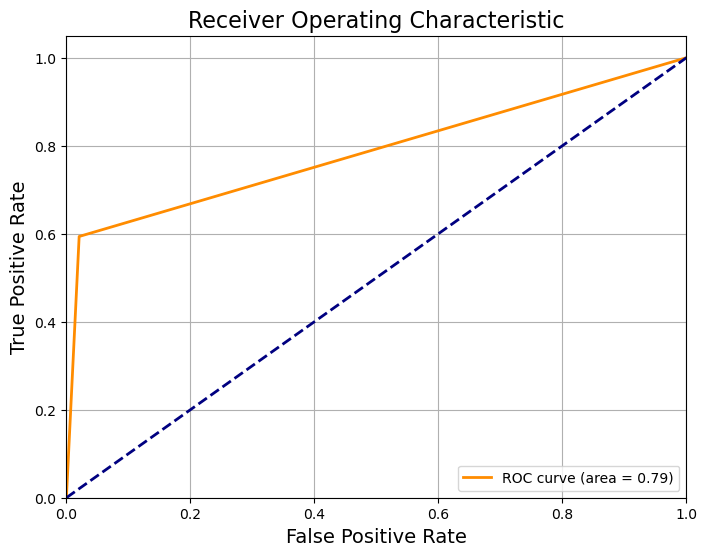

In [29]:
# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

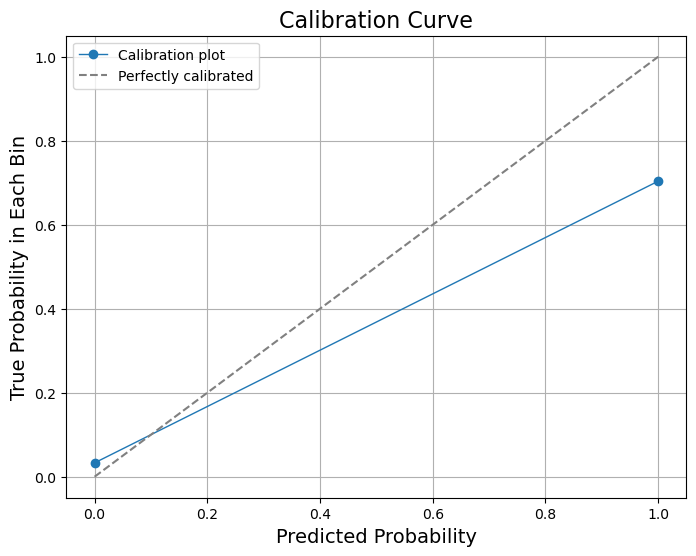

In [30]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins = 10)

plt.figure(figsize = (8, 6))
plt.plot(prob_pred, prob_true, marker = 'o', linewidth = 1, label = 'Calibration plot')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Perfectly calibrated')
plt.xlabel('Predicted Probability', fontsize = 14)
plt.ylabel('True Probability in Each Bin', fontsize = 14)
plt.title('Calibration Curve', fontsize = 16)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [185]:
joblib.dump(XGBC,"XGBC_large.joblib")

['XGBC_large.joblib']

#### Random Forest

In [47]:
# Creating a pipeline that includes preprocessing and the classifier
RFC = ImbPipeline(steps=[('preprocessor', preprocessor),
                        ('smote', smote),
                         ('classifier', RandomForestClassifier(max_depth = 7,n_estimators = 300))])

# Fitting the model
RFC.fit(X_train, y_train)

# Model evaluation
train_score = RFC.score(X_train, y_train)
test_score = RFC.score(X_test, y_test)

print(train_score, test_score)

y_pred = RFC.predict(X_test)
y_proba = RFC.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

probabilities = RFC.predict_proba(X_test)

# Extracting the probability of death, which is the second column of probabilities
death_probabilities = probabilities[:, 1]

# Showing the first few predictions for interpretation
death_probabilities[:10]

0.9803921568627451 0.9524940617577197


array([0.04387708, 0.09323058, 0.05259856, 0.70407827, 0.07373288,
       0.36354675, 0.44126808, 0.14329608, 0.0792429 , 0.08243815])

In [48]:
accuracy, precision, recall, f1, roc_auc

(0.9524940617577197, 0.7, 0.65625, 0.6774193548387096, 0.9398296915167095)

In [50]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       389
           1       0.70      0.59      0.64        32

    accuracy                           0.95       421
   macro avg       0.84      0.79      0.81       421
weighted avg       0.95      0.95      0.95       421



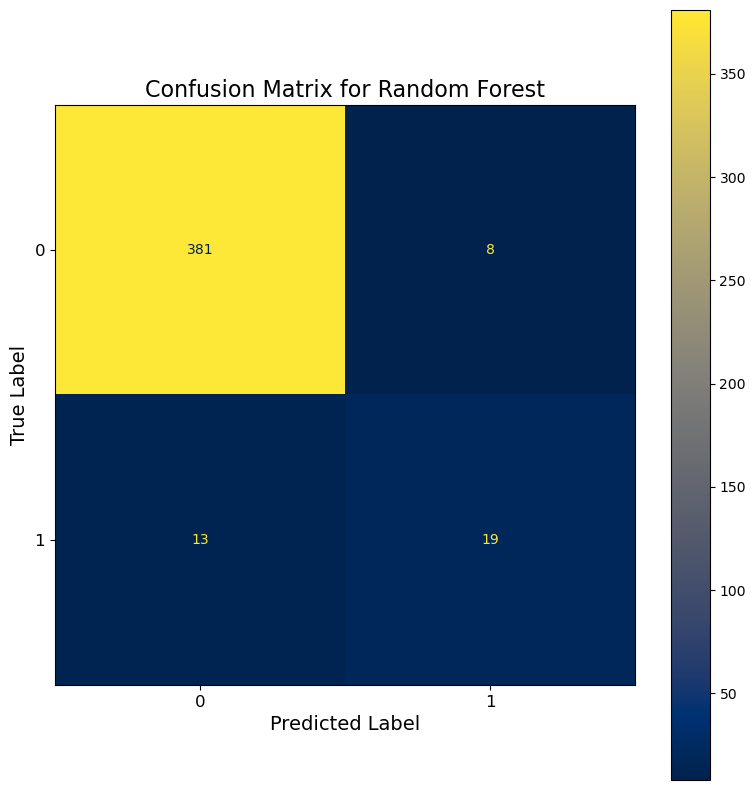

In [58]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Create the Confusion Matrix object
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(y_test))

# Plot with enhanced color scheme
fig, ax = plt.subplots(figsize = (8, 8))
cmap = plt.cm.cividis  

disp.plot(cmap = cmap, ax = ax, colorbar = True)
ax.set_title('Confusion Matrix for Random Forest', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12) 

ax.grid(False)

plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.tight_layout() 
plt.show()

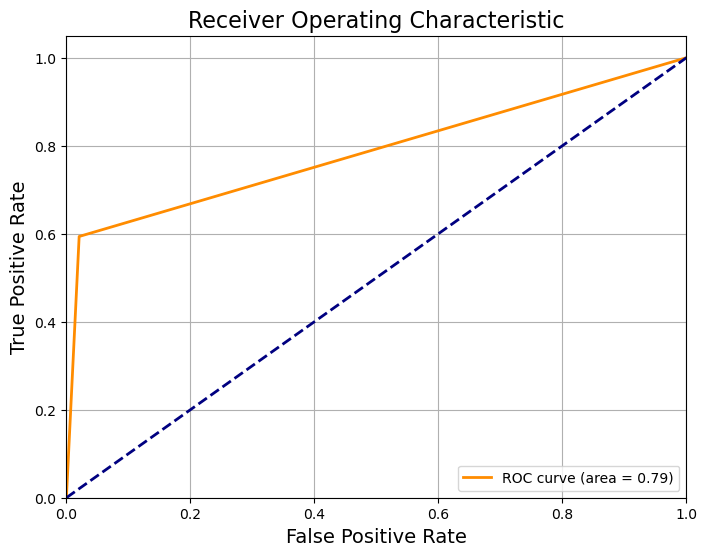

In [59]:
# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('Receiver Operating Characteristic', fontsize = 16)
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()

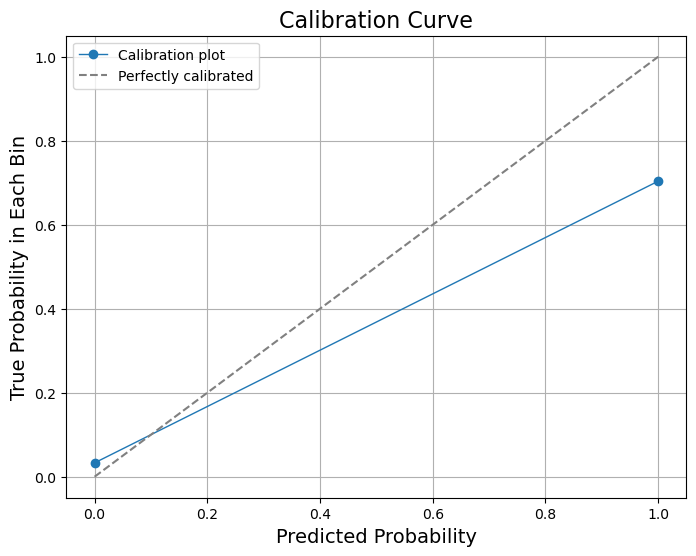

In [60]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins = 10)

plt.figure(figsize = (8, 6))
plt.plot(prob_pred, prob_true, marker = 'o', linewidth = 1, label = 'Calibration plot')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Perfectly calibrated')
plt.xlabel('Predicted Probability', fontsize = 14)
plt.ylabel('True Probability in Each Bin', fontsize = 14)
plt.title('Calibration Curve', fontsize = 16)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Top 10 Deadly Diseases

In [61]:
AP_data = X[X['Acute pancreatitis']==True]

probabilities = RFC.predict_proba(AP_data)

# Get the probabilities of death class (assuming it's the second column, index 1)
death_probabilities = probabilities[:, 1]

# Combine with the test set for a complete view
X_with_prob = pd.DataFrame(AP_data.copy())
X_with_prob['Death_Probability'] = death_probabilities

# Sort the dataframe by 'Death_Probability' in descending order to get the highest probabilities at the top
X_with_prob_sorted = X_with_prob.sort_values(by = 'Death_Probability', ascending=False)

# Display the top 10 instances with the highest death probability
print(X_with_prob_sorted.iloc[0])

gender                                                                                                                F
race                                                                                                              WHITE
lipase_level                                                                                                      753.0
actual_age                                                                                                           77
charlson_comorbidity_index                                                                                            6
                                                                                                                 ...   
Viral hepatitis B without mention of hepatic coma, acute or unspecified, without mention of hepatitis delta       False
Vitamin B12 deficiency anemia due to intrinsic factor deficiency                                                  False
Volvulus                                

In [92]:
def deadly_disease(n):
    true_columns = []
    start_ind = X_with_prob_sorted.columns.get_loc('length_of_stay')+1
    for i in range(n):
        row_data = X_with_prob_sorted.iloc[i][start_ind:]
        true_columns = true_columns + row_data[row_data == True].index.tolist()
    return true_columns

In [104]:
death_data = X_with_prob_sorted[X_with_prob_sorted.Death_Probability>=0.3]
len(death_data)

191

In [105]:
# finding top occuring disease for patients diagnosed with AP and has 30 % chance of death 
data = Counter(deadly_disease(len(death_data)))
data

Counter({'Acute pancreatitis': 191,
         'Acidosis': 96,
         'Acute kidney failure, unspecified': 88,
         'Acute respiratory failure': 79,
         'Severe sepsis': 62,
         'Acute kidney failure with lesion of tubular necrosis': 53,
         'Unspecified septicemia': 46,
         'Atrial fibrillation': 46,
         'Septic shock': 41,
         'Acute posthemorrhagic anemia': 41,
         'Thrombocytopenia, unspecified': 40,
         'Hyperosmolality and/or hypernatremia': 39,
         'Congestive heart failure, unspecified': 37,
         'Encounter for palliative care': 37,
         'Acute respiratory failure with hypoxia': 34,
         'Acute and subacute necrosis of liver': 33,
         'Other ascites': 30,
         'Acute kidney failure with tubular necrosis': 27,
         'Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified': 26,
         'Coronary atherosclerosis of native coronary artery': 25,
 

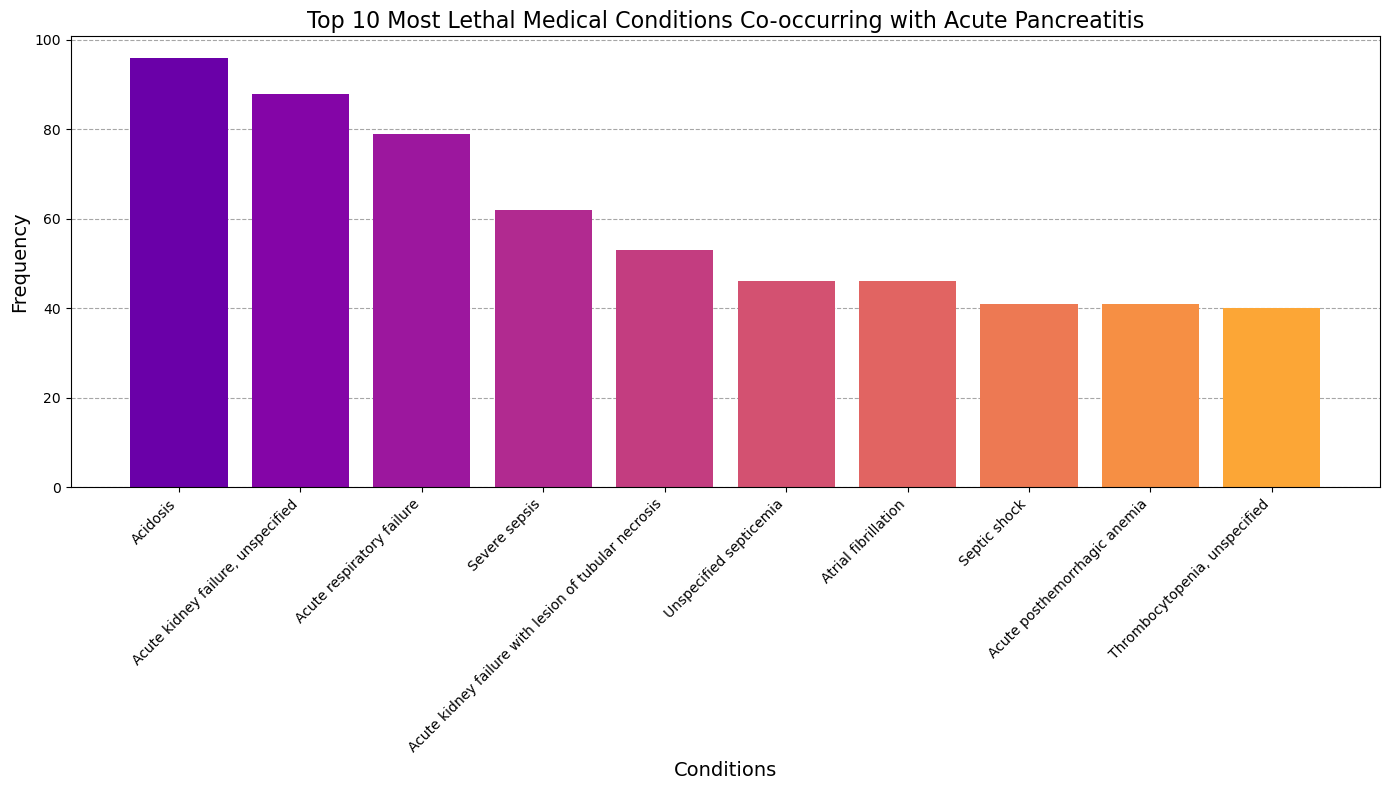

In [106]:
labels, values = zip(*sorted(data.items(), key=lambda item: item[1], reverse=True))

# Creating the bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(labels[1:11], values[1:11], color=plt.cm.plasma(np.linspace(0.2, 0.8, len(labels[:10]))))

# Adding labels and titles
ax.set_title('Top 10 Most Lethal Medical Conditions Co-occurring with Acute Pancreatitis', fontsize=16)
ax.set_xlabel('Conditions', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Optional: Adding a grid
ax.set_axisbelow(True)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.7)

# Optional: Improve layout and padding adjustments
plt.tight_layout()

# Show the plot
plt.show()